# World Wide Products Inc.

a project for EECS 731 by Benjamin Wyss

Examining historical product demand data to build time series forecasting models which predict the future demand for products

###### python imports

In [558]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Reading Data Sets From CSV

Historical Product Demand

Taken from: https://www.kaggle.com/felixzhao/productdemandforecasting on 10/6/20

###### Historical Product Demand Data Set

In [440]:
df = pd.read_csv('../data/raw/Historical Product Demand.csv')

In [441]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


## The Big Ideas

Feature engineering and transformation can add value to this data set for building time series forecasting models in the following ways:

(1): By splitting the Date column into multiple columns for day of week, day of month, day of year, week, month, and year, time interval granularity can be adjusted to yield the best results.

(2): By one-hot encoding the Warehouse column, time series forecasting models can reason about the demand for a product at different warehouses, which should improve the model's results if different warehouses have different magnitudes of demand.

(3): By selecting only the most promising and demand-correlated attributes as input features, time series forecasting models can achieve better results which are not tainted by detrimental input features.

(4): By separating the data set into multiple data sets which correspond to a single product, separate time series forecasting models can be built for each product so that each model achieves the best possible results.

## Exploratory Data Analysis

### Cleaning the Data Set

The Product_Category column is removed since I will be building time series forecasting models on a per-product basis. Since an individual product's category should not change throughout time, this column does not add any value to a time series forecasting model.

In [442]:
df = df[['Product_Code', 'Warehouse', 'Date', 'Order_Demand']]

In [443]:
df

,Product_Code,Warehouse,Date,Order_Demand
0,Product_0993,Whse_J,2012/7/27,100
1,Product_0979,Whse_J,2012/1/19,500
2,Product_0979,Whse_J,2012/2/3,500
3,Product_0979,Whse_J,2012/2/9,500
4,Product_0979,Whse_J,2012/3/2,500
...,...,...,...,...
1048570,Product_1791,Whse_J,2016/4/27,1000
1048571,Product_1974,Whse_J,2016/4/27,1
1048572,Product_1787,Whse_J,2016/4/28,2500
1048573,Product_0901,Whse_J,2016/10/7,50


The Product_Code and Warehouse columns' prefixes are removed so that the data set is easier to read.

In [444]:
df['Product_Code'] = df['Product_Code'].str[-4:]
df['Warehouse'] = df['Warehouse'].str[-1:]

In [445]:
df

,Product_Code,Warehouse,Date,Order_Demand
0,0993,J,2012/7/27,100
1,0979,J,2012/1/19,500
2,0979,J,2012/2/3,500
3,0979,J,2012/2/9,500
4,0979,J,2012/3/2,500
...,...,...,...,...
1048570,1791,J,2016/4/27,1000
1048571,1974,J,2016/4/27,1
1048572,1787,J,2016/4/28,2500
1048573,0901,J,2016/10/7,50


The Order_Demand column is converted to a numeric type so that time series forecasting models can reason about the data.

When converting the Order_Demand column to a numeric type, some rows have a negative demand (indicated with parentheses). A product should not be able to have a negative demand, so these rows are dropped.

In [446]:
df = df[df.Order_Demand.str[0] != '(']
df['Order_Demand'] = df['Order_Demand'].astype(float)

In [447]:
df

,Product_Code,Warehouse,Date,Order_Demand
0,0993,J,2012/7/27,100.0
1,0979,J,2012/1/19,500.0
2,0979,J,2012/2/3,500.0
3,0979,J,2012/2/9,500.0
4,0979,J,2012/3/2,500.0
...,...,...,...,...
1048570,1791,J,2016/4/27,1000.0
1048571,1974,J,2016/4/27,1.0
1048572,1787,J,2016/4/28,2500.0
1048573,0901,J,2016/10/7,50.0


The data set is sorted by the Date column so that time series forecasting models can be trained sequentially by date.

In [448]:
df = df.sort_values(by=['Date'])

In [449]:
df

,Product_Code,Warehouse,Date,Order_Demand
44799,0965,A,2011/1/8,2.0
75193,0642,C,2011/10/31,3.0
44795,0965,A,2011/11/18,1.0
44450,0980,A,2011/11/18,4000.0
44796,0965,A,2011/11/21,3.0
...,...,...,...,...
901973,1423,A,NaN,500.0
901974,1424,A,NaN,1400.0
901975,1419,A,NaN,600.0
981716,0130,A,NaN,20.0


Some rows have no listed Date attribute. These rows are dropped from the data set because date information is necessary to build time series forecasting models.

In [450]:
df = df.dropna()

In [451]:
df

,Product_Code,Warehouse,Date,Order_Demand
44799,0965,A,2011/1/8,2.0
75193,0642,C,2011/10/31,3.0
44795,0965,A,2011/11/18,1.0
44450,0980,A,2011/11/18,4000.0
44796,0965,A,2011/11/21,3.0
...,...,...,...,...
920140,0025,J,2017/1/6,500.0
921384,1316,J,2017/1/6,10000.0
863020,1904,C,2017/1/9,4000.0
908844,0471,C,2017/1/9,30.0


### Transforming the data set

##### Column Splitting the Date Column

The Date column is split into  columns--DayOfWeek, DayOfMonth, DayOfYear, Week, Month, and Year, so that different numeric representations of this data is obtained. Once this column is split, the original Date column is removed from the data set because it is a textual representation of the data which a time series forecasting model cannot reason about.

In [452]:
dateSeries = pd.to_datetime(df['Date'], format='%Y/%m/%d', errors='coerce')
df['DayOfWeek'] = dateSeries.dt.dayofweek
df['DayOfMonth'] = dateSeries.dt.day
df['DayOfYear'] = dateSeries.dt.dayofyear
df['Week'] = dateSeries.dt.weekofyear
df['Month'] = dateSeries.dt.month
df['Year'] = dateSeries.dt.year
date = df.pop('Date')

In [453]:
df

,Product_Code,Warehouse,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year
44799,0965,A,2.0,5,8,8,1,1,2011
75193,0642,C,3.0,0,31,304,44,10,2011
44795,0965,A,1.0,4,18,322,46,11,2011
44450,0980,A,4000.0,4,18,322,46,11,2011
44796,0965,A,3.0,0,21,325,47,11,2011
...,...,...,...,...,...,...,...,...,...
920140,0025,J,500.0,4,6,6,1,1,2017
921384,1316,J,10000.0,4,6,6,1,1,2017
863020,1904,C,4000.0,0,9,9,2,1,2017
908844,0471,C,30.0,0,9,9,2,1,2017


##### Transforming the Year Column to start at Year 0

To prevent time series forecasting models from treating the Year column with higher influence because it has a large minimum value, the Year column is transformed to begin at year 0

In [454]:
df['Year'] = df.Year - 2011

In [455]:
df

,Product_Code,Warehouse,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year
44799,0965,A,2.0,5,8,8,1,1,0
75193,0642,C,3.0,0,31,304,44,10,0
44795,0965,A,1.0,4,18,322,46,11,0
44450,0980,A,4000.0,4,18,322,46,11,0
44796,0965,A,3.0,0,21,325,47,11,0
...,...,...,...,...,...,...,...,...,...
920140,0025,J,500.0,4,6,6,1,1,6
921384,1316,J,10000.0,4,6,6,1,1,6
863020,1904,C,4000.0,0,9,9,2,1,6
908844,0471,C,30.0,0,9,9,2,1,6


##### One-Hot Encoding the Warehouse column

Because different warehouses might differ in terms of demand magnitude, the warehouse column is one-hot encoded so that time series forecasting models can distinguish between different warehouses. One-hot encoding is selected over label encoding because label encoding introduces arbitrary distances between different warehouses which will influence a time series forecasting model

In [456]:
df = pd.get_dummies(df, columns=['Warehouse'])

In [457]:
df

,Product_Code,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S
44799,0965,2.0,5,8,8,1,1,0,1,0,0,0
75193,0642,3.0,0,31,304,44,10,0,0,1,0,0
44795,0965,1.0,4,18,322,46,11,0,1,0,0,0
44450,0980,4000.0,4,18,322,46,11,0,1,0,0,0
44796,0965,3.0,0,21,325,47,11,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
920140,0025,500.0,4,6,6,1,1,6,0,0,1,0
921384,1316,10000.0,4,6,6,1,1,6,0,0,1,0
863020,1904,4000.0,0,9,9,2,1,6,0,1,0,0
908844,0471,30.0,0,9,9,2,1,6,0,1,0,0


### Exporting Transformed Data Set to CSV

In [458]:
df.to_csv('../data/processed/product_demand_transformed.csv')

### Visualizing the Data

First, some basic statistics of the data set and correlation coefficients are calculated. 

Observe that each warehouse has a small correlaiton coefficient with product demand, meaning that each warehouse does differ slightly in terms of demand magnitude. Thus, the warehouse columns will be included as input features in the time series forecasting models that will be tested.

In [459]:
df.describe()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S
count,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06,1.031437e+06
mean,4.962992e+03,2.022948e+00,1.557185e+01,1.826344e+02,2.669519e+01,6.508216e+00,2.961957e+00,1.362274e-01,4.094967e-02,7.377009e-01,8.512202e-02
std,2.911306e+04,1.440711e+00,8.801473e+00,1.050001e+02,1.499797e+01,3.446524e+00,1.388986e+00,3.430301e-01,1.981737e-01,4.398846e-01,2.790633e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+01,1.000000e+00,8.000000e+00,9.000000e+01,1.300000e+01,3.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+02,2.000000e+00,1.600000e+01,1.830000e+02,2.700000e+01,7.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,2.000000e+03,3.000000e+00,2.300000e+01,2.750000e+02,4.000000e+01,1.000000e+01,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,4.000000e+06,6.000000e+00,3.100000e+01,3.660000e+02,5.300000e+01,1.200000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [460]:
df.corr()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S
Order_Demand,1.000000,-0.004203,-0.001938,-0.000875,-0.001237,-0.000694,0.008237,-0.053568,0.062821,-0.031981,0.071647
DayOfWeek,-0.004203,1.000000,0.021295,0.011162,-0.000048,0.009413,-0.015028,0.010795,-0.013071,-0.001705,-0.001299
DayOfMonth,-0.001938,0.021295,1.000000,0.049037,0.044811,-0.034732,-0.006973,0.006831,0.009493,-0.014727,0.008075
DayOfYear,-0.000875,0.011162,0.049037,1.000000,0.995683,0.996466,-0.008407,0.013247,0.013284,-0.016749,0.000684
Week,-0.001237,-0.000048,0.044811,0.995683,1.000000,0.992567,-0.009110,0.013399,0.010180,-0.013627,-0.002219
Month,-0.000694,0.009413,-0.034732,0.996466,0.992567,1.000000,-0.007795,0.012712,0.012515,-0.015708,0.000248
Year,0.008237,-0.015028,-0.006973,-0.008407,-0.009110,-0.007795,1.000000,-0.014825,0.031343,0.031305,-0.053381
Warehouse_A,-0.053568,0.010795,0.006831,0.013247,0.013399,0.012712,-0.014825,1.000000,-0.082061,-0.666000,-0.121136
Warehouse_C,0.062821,-0.013071,0.009493,0.013284,0.010180,0.012515,0.031343,-0.082061,1.000000,-0.346534,-0.063029
Warehouse_J,-0.031981,-0.001705,-0.014727,-0.016749,-0.013627,-0.015708,0.031305,-0.666000,-0.346534,1.000000,-0.511542


###### Generating Interesting Plots

Because this data set contains a large variety of diverse products, I will examine three specific products that show somewhat predictable demand patterns. This will allow well-engineered time series forecasting models to predict these products' demands with decent performance. 

To select the best products for building time series forecasting models, I will generate some candidate product demand plots and select the ones which show some predictable demand and have a reasonable number of instances. To aid myself in generating plots that can be reasoned about, I will generate a new Column which records days since the first day of year zero. This will serve as the independent variable for my initial demand plots. The calculation used to generate this column assumes that no leap years occur, and so the calculation will likely be off by a day or two for some rows. This should not affect the overall shape of demand plots, however, so I should still be able to reason about the generated demand plots.

In [461]:
df['AbsoluteDay'] = df.DayOfYear + df.Year * 365

In [462]:
df

,Product_Code,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
44799,0965,2.0,5,8,8,1,1,0,1,0,0,0,8
75193,0642,3.0,0,31,304,44,10,0,0,1,0,0,304
44795,0965,1.0,4,18,322,46,11,0,1,0,0,0,322
44450,0980,4000.0,4,18,322,46,11,0,1,0,0,0,322
44796,0965,3.0,0,21,325,47,11,0,1,0,0,0,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
920140,0025,500.0,4,6,6,1,1,6,0,0,1,0,2196
921384,1316,10000.0,4,6,6,1,1,6,0,0,1,0,2196
863020,1904,4000.0,0,9,9,2,1,6,0,1,0,0,2199
908844,0471,30.0,0,9,9,2,1,6,0,1,0,0,2199


##### Product 1135

Product 1135 has a decent number of instances (1171) and shows a slight average demand decrease over time. A time series forecasting model should be able to predict this pattern, so I will build a model which predicts the demand of Product 1135.

Now, generate some different plots and statistics for this product's subset of the data set

<AxesSubplot:title={'center':'Product 1135 Demand by Day'}, xlabel='AbsoluteDay', ylabel='Order_Demand'>

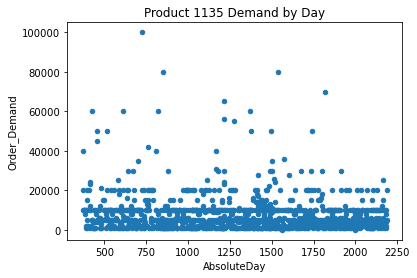

In [463]:
df[df['Product_Code'] == '1135'].plot.scatter(x='AbsoluteDay', y='Order_Demand', title='Product 1135 Demand by Day')

<AxesSubplot:title={'center':'Product 1135 Demand by Day of Month'}, xlabel='DayOfMonth', ylabel='Order_Demand'>

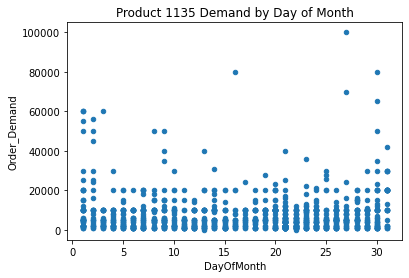

In [464]:
df[df['Product_Code'] == '1135'].plot.scatter(x='DayOfMonth', y='Order_Demand', title='Product 1135 Demand by Day of Month')

<AxesSubplot:title={'center':'Product 1135 Demand by Week'}, xlabel='Week', ylabel='Order_Demand'>

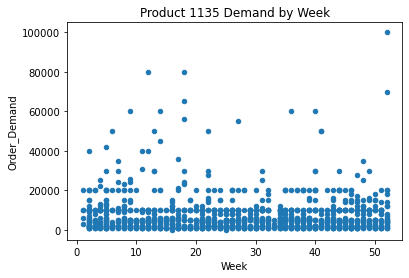

In [465]:
df[df['Product_Code'] == '1135'].plot.scatter(x='Week', y='Order_Demand', title='Product 1135 Demand by Week')

<AxesSubplot:title={'center':'Product 1135 Demand by Month'}, xlabel='Month', ylabel='Order_Demand'>

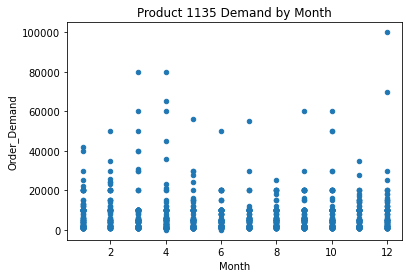

In [466]:
df[df['Product_Code'] == '1135'].plot.scatter(x='Month', y='Order_Demand', title='Product 1135 Demand by Month')

<AxesSubplot:title={'center':'Product 1135 Demand by Year'}, xlabel='Year', ylabel='Order_Demand'>

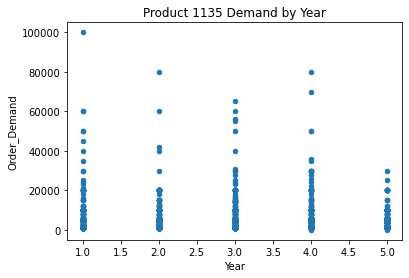

In [467]:
df[df['Product_Code'] == '1135'].plot.scatter(x='Year', y='Order_Demand', title='Product 1135 Demand by Year')

In [468]:
df[df['Product_Code'] == '1135'].describe()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.0,1171.00000,1171.000000,1171.000000,1171.000000
mean,7601.195559,2.031597,16.477370,185.631939,27.100769,6.576430,3.126388,0.0,0.10333,0.865073,0.031597,1326.763450
std,9220.599306,1.475101,9.008645,104.382091,14.915893,3.435102,1.392684,0.0,0.30452,0.341792,0.174999,516.641982
min,0.000000,0.000000,1.000000,5.000000,1.000000,1.000000,1.000000,0.0,0.00000,0.000000,0.000000,370.000000
25%,2000.000000,1.000000,9.000000,95.500000,14.000000,4.000000,2.000000,0.0,0.00000,1.000000,0.000000,888.500000
50%,5000.000000,2.000000,18.000000,183.000000,27.000000,7.000000,3.000000,0.0,0.00000,1.000000,0.000000,1350.000000
75%,10000.000000,3.000000,24.000000,275.000000,40.000000,10.000000,4.000000,0.0,0.00000,1.000000,0.000000,1771.500000
max,100000.000000,6.000000,31.000000,364.000000,52.000000,12.000000,5.000000,0.0,1.00000,1.000000,1.000000,2188.000000


In [469]:
df[df['Product_Code'] == '1135'].corr()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
Order_Demand,1.000000,0.059996,0.006687,-0.030333,-0.028350,-0.030946,-0.131252,NaN,-0.016968,-0.059125,0.145005,-0.135268
DayOfWeek,0.059996,1.000000,0.071543,-0.029133,-0.041360,-0.035140,-0.040222,NaN,0.030780,-0.022051,-0.010493,-0.045461
DayOfMonth,0.006687,0.071543,1.000000,0.016815,0.012840,-0.068917,-0.034106,NaN,-0.007092,0.005669,0.001267,-0.030160
DayOfYear,-0.030333,-0.029133,0.016815,1.000000,0.994556,0.996297,-0.022386,NaN,-0.009343,0.001338,0.013645,0.180014
Week,-0.028350,-0.041360,0.012840,0.994556,1.000000,0.991275,-0.025630,NaN,-0.018665,0.008369,0.016133,0.175722
Month,-0.030946,-0.035140,-0.068917,0.996297,0.991275,1.000000,-0.019887,NaN,-0.008782,0.000783,0.013752,0.181725
Year,-0.131252,-0.040222,-0.034106,-0.022386,-0.025630,-0.019887,1.000000,NaN,-0.008652,-0.014420,0.043218,0.979388
Warehouse_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Warehouse_C,-0.016968,0.030780,-0.007092,-0.009343,-0.018665,-0.008782,-0.008652,NaN,1.000000,-0.859556,-0.061319,-0.010400
Warehouse_J,-0.059125,-0.022051,0.005669,0.001338,0.008369,0.000783,-0.014420,NaN,-0.859556,1.000000,-0.457373,-0.013917


##### Product 1222

This product has a good number of instances (3453) and shows demand spikes that occur at semi-regular intervals. A time series forecasting model should be able to predict this pattern, so I will build a time series forecasting model for this product.

Now, generate some different plots and statistics for this product's subset of the data set

<AxesSubplot:title={'center':'Product 1222 Demand by Day'}, xlabel='AbsoluteDay', ylabel='Order_Demand'>

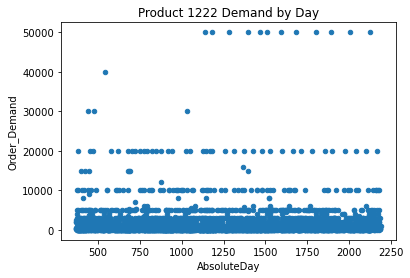

In [470]:
df[df['Product_Code'] == '1222'].plot.scatter(x='AbsoluteDay', y='Order_Demand', title='Product 1222 Demand by Day')

<AxesSubplot:title={'center':'Product 1222 Demand by Day of Month'}, xlabel='DayOfMonth', ylabel='Order_Demand'>

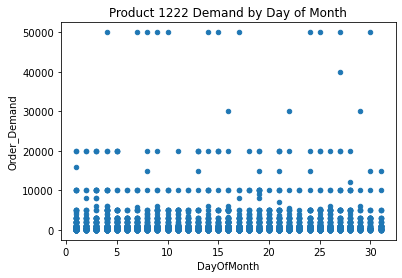

In [471]:
df[df['Product_Code'] == '1222'].plot.scatter(x='DayOfMonth', y='Order_Demand', title='Product 1222 Demand by Day of Month')

<AxesSubplot:title={'center':'Product 1222 Demand by Week'}, xlabel='Week', ylabel='Order_Demand'>

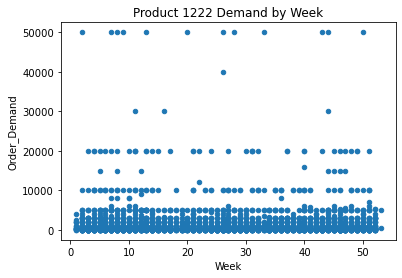

In [472]:
df[df['Product_Code'] == '1222'].plot.scatter(x='Week', y='Order_Demand', title='Product 1222 Demand by Week')

<AxesSubplot:title={'center':'Product 1222 Demand by Month'}, xlabel='Month', ylabel='Order_Demand'>

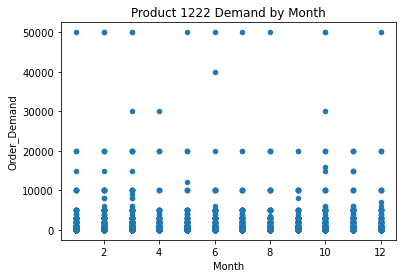

In [473]:
df[df['Product_Code'] == '1222'].plot.scatter(x='Month', y='Order_Demand', title='Product 1222 Demand by Month')

<AxesSubplot:title={'center':'Product 1222 Demand by Year'}, xlabel='Year', ylabel='Order_Demand'>

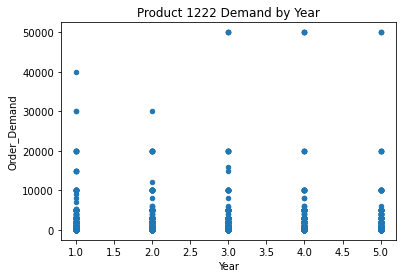

In [474]:
df[df['Product_Code'] == '1222'].plot.scatter(x='Year', y='Order_Demand', title='Product 1222 Demand by Year')

In [475]:
df[df['Product_Code'] == '1222'].describe()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
count,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.0,3453.0,3453.000000,3453.000000,3453.000000
mean,1690.414133,1.960614,15.536056,178.624964,26.159571,6.376484,2.889082,0.0,0.0,0.990443,0.009557,1233.139878
std,4130.027843,1.443474,8.705108,107.365410,15.332460,3.537114,1.400269,0.0,0.0,0.097305,0.097305,522.432214
min,0.000000,0.000000,1.000000,5.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,370.000000
25%,200.000000,1.000000,8.000000,77.000000,12.000000,3.000000,2.000000,0.0,0.0,1.000000,0.000000,776.000000
50%,500.000000,2.000000,16.000000,180.000000,26.000000,6.000000,3.000000,0.0,0.0,1.000000,0.000000,1189.000000
75%,1500.000000,3.000000,23.000000,274.000000,40.000000,10.000000,4.000000,0.0,0.0,1.000000,0.000000,1690.000000
max,50000.000000,6.000000,31.000000,363.000000,53.000000,12.000000,5.000000,0.0,0.0,1.000000,1.000000,2188.000000


In [476]:
df[df['Product_Code'] == '1222'].corr()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
Order_Demand,1.000000,0.000500,-0.004061,-0.012375,-0.012196,-0.011974,0.012199,NaN,NaN,0.023776,-0.023776,0.009391
DayOfWeek,0.000500,1.000000,0.002488,0.030548,0.017208,0.030026,-0.024520,NaN,NaN,-0.037742,0.037742,-0.017710
DayOfMonth,-0.004061,0.002488,1.000000,0.004489,0.004629,-0.076092,0.022561,NaN,NaN,0.005366,-0.005366,0.022994
DayOfYear,-0.012375,0.030548,0.004489,1.000000,0.999723,0.996724,0.001702,NaN,NaN,-0.023275,0.023275,0.207176
Week,-0.012196,0.017208,0.004629,0.999723,1.000000,0.996504,0.000649,NaN,NaN,-0.023831,0.023831,0.206089
Month,-0.011974,0.030026,-0.076092,0.996724,0.996504,1.000000,0.000187,NaN,NaN,-0.024052,0.024052,0.205020
Year,0.012199,-0.024520,0.022561,0.001702,0.000649,0.000187,1.000000,NaN,NaN,-0.001404,0.001404,0.978655
Warehouse_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Warehouse_C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Warehouse_J,0.023776,-0.037742,0.005366,-0.023275,-0.023831,-0.024052,-0.001404,NaN,NaN,1.000000,-1.000000,-0.006157


##### Product  1991

Product 1991 has a good number of instances (3437) and shows demand that mostly oscilates between low and high demand. A time series forecasting model should be able to predict this pattern, so I will build a time series forecasting model for product 1991's demand.

Now, generate some different plots and statistics for this product's subset of the data set

<AxesSubplot:title={'center':'Product 1991 Demand by Day'}, xlabel='AbsoluteDay', ylabel='Order_Demand'>

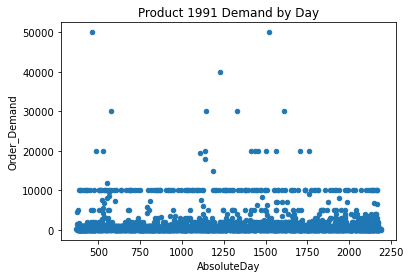

In [477]:
df[df['Product_Code'] == '1991'].plot.scatter(x='AbsoluteDay', y='Order_Demand', title='Product 1991 Demand by Day')

<AxesSubplot:title={'center':'Product 1991 Demand by Day of Month'}, xlabel='DayOfMonth', ylabel='Order_Demand'>

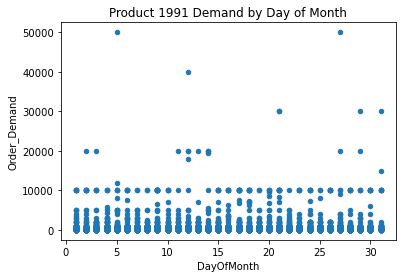

In [478]:
df[df['Product_Code'] == '1991'].plot.scatter(x='DayOfMonth', y='Order_Demand', title='Product 1991 Demand by Day of Month')

<AxesSubplot:title={'center':'Product 1991 Demand by Week'}, xlabel='Week', ylabel='Order_Demand'>

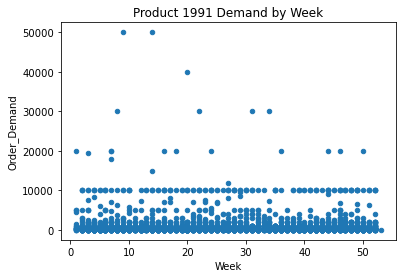

In [479]:
df[df['Product_Code'] == '1991'].plot.scatter(x='Week', y='Order_Demand', title='Product 1991 Demand by Week')

<AxesSubplot:title={'center':'Product 1991 Demand by Month'}, xlabel='Month', ylabel='Order_Demand'>

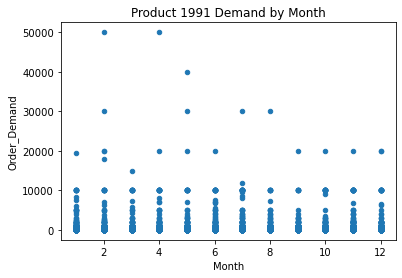

In [480]:
df[df['Product_Code'] == '1991'].plot.scatter(x='Month', y='Order_Demand', title='Product 1991 Demand by Month')

<AxesSubplot:title={'center':'Product 1991 Demand by Year'}, xlabel='Year', ylabel='Order_Demand'>

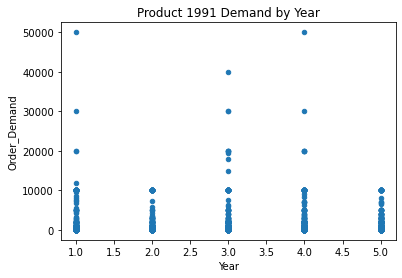

In [481]:
df[df['Product_Code'] == '1991'].plot.scatter(x='Year', y='Order_Demand', title='Product 1991 Demand by Year')

In [482]:
df[df['Product_Code'] == '1991'].describe()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
count,3437.000000,3437.000000,3437.000000,3437.000000,3437.000000,3437.000000,3437.000000,3437.0,3437.000000,3437.000000,3437.0,3437.000000
mean,1148.297934,2.004946,15.920570,180.990690,26.466104,6.442246,3.068665,0.0,0.037824,0.962176,0.0,1301.053244
std,2840.795162,1.418623,8.740991,103.717754,14.810967,3.404860,1.423014,0.0,0.190797,0.190797,0.0,533.254455
min,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.0,368.000000
25%,100.000000,1.000000,8.000000,91.000000,14.000000,3.000000,2.000000,0.0,0.000000,1.000000,0.0,842.000000
50%,300.000000,2.000000,16.000000,180.000000,26.000000,6.000000,3.000000,0.0,0.000000,1.000000,0.0,1325.000000
75%,1000.000000,3.000000,23.000000,274.000000,40.000000,9.000000,4.000000,0.0,0.000000,1.000000,0.0,1759.000000
max,50000.000000,6.000000,31.000000,363.000000,53.000000,12.000000,5.000000,0.0,1.000000,1.000000,0.0,2188.000000


In [483]:
df[df['Product_Code'] == '1991'].corr()

,Order_Demand,DayOfWeek,DayOfMonth,DayOfYear,Week,Month,Year,Warehouse_A,Warehouse_C,Warehouse_J,Warehouse_S,AbsoluteDay
Order_Demand,1.000000,0.029672,-0.002302,-0.002872,-0.009550,-0.002732,-0.005565,NaN,-0.030971,0.030971,NaN,-0.005979
DayOfWeek,0.029672,1.000000,0.031224,0.038126,0.025793,0.035578,0.025926,NaN,-0.020046,0.020046,NaN,0.032668
DayOfMonth,-0.002302,0.031224,1.000000,0.047939,0.045930,-0.036370,-0.025603,NaN,-0.027166,0.027166,NaN,-0.015614
DayOfYear,-0.002872,0.038126,0.047939,1.000000,0.997922,0.996420,0.035514,NaN,-0.035308,0.035308,NaN,0.229091
Week,-0.009550,0.025793,0.045930,0.997922,1.000000,0.994584,0.032216,NaN,-0.040227,0.040227,NaN,0.225474
Month,-0.002732,0.035578,-0.036370,0.996420,0.994584,1.000000,0.037640,NaN,-0.032924,0.032924,NaN,0.230465
Year,-0.005565,0.025926,-0.025603,0.035514,0.032216,0.037640,1.000000,NaN,0.020446,-0.020446,NaN,0.980927
Warehouse_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Warehouse_C,-0.030971,-0.020046,-0.027166,-0.035308,-0.040227,-0.032924,0.020446,NaN,1.000000,-1.000000,NaN,0.013047
Warehouse_J,0.030971,0.020046,0.027166,0.035308,0.040227,0.032924,-0.020446,NaN,-1.000000,1.000000,NaN,-0.013047


### Model Construction

For each product, a variety of machine learning regression models using a variety of input features will be tested and compared based on their average coefficient of determination (r2_score).

First, the pandas dataframe is converted to numpy arrays of input features (X arrays) and output regression targets (Y arrays). For each product, I will test a time series model trained with all time information, a model trained with week and year information, a model trained with day of month, month, and year information, and a model trained with day of year and year information. This will allow me to test different time granularities and select the best performing one for each product.

In [484]:
df1135 = df[df['Product_Code'] == '1135']
df1222 = df[df['Product_Code'] == '1222']
df1991 = df[df['Product_Code'] == '1991']

Y1135 = df1135.Order_Demand.values
Y1222 = df1222.Order_Demand.values
Y1991 = df1991.Order_Demand.values

X1135_all = df1135[['DayOfWeek', 'DayOfMonth', 'DayOfYear', 'Week', 'Month', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1135_week = df1135[['Week', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1135_month = df1135[['DayOfMonth', 'Month', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1135_day = df1135[['DayOfYear', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values

X1222_all = df1222[['DayOfWeek', 'DayOfMonth', 'DayOfYear', 'Week', 'Month', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1222_week = df1222[['Week', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1222_month = df1222[['DayOfMonth', 'Month', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1222_day = df1222[['DayOfYear', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values

X1991_all = df1991[['DayOfWeek', 'DayOfMonth', 'DayOfYear', 'Week', 'Month', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1991_week = df1991[['Week', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1991_month = df1991[['DayOfMonth', 'Month', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values
X1991_day = df1991[['DayOfYear', 'Year', 'Warehouse_A', 'Warehouse_C', 'Warehouse_J', 'Warehouse_S']].values

### Testing Different Models With 10-Split Time Series Validation

I will test Random Forest Regressor, Gradient Boosting Regressor, and Multi-layer Perceptron (MLP) Neural Network Regressor models for each product and each input feature set to determine the best performing model and time series granularity. These models were selected because ensemble approaches generally have good baseline performance and I wanted to compare the ensemble approaches' performance to the performance of a simple neural network.

Average 10-split time series validation r2_score is selected as the scoring metric because 10-split time series validation will reduce overfitting, and the target model should be the model with predictions most closely matching the actual data throughout time.

#### Generating a n_splits=10 Time Series Validation Object to Use for Testing

In [485]:
tsplit = TimeSeriesSplit(n_splits=10)

##### Product 1135 Random Forest With All Time Information

In [486]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_all):
    X_train = X1135_all[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_all[test_index]
    Y_test = Y1135[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [487]:
np.mean(r2_scores)

-0.4164980648896262

##### Product 1135 Random Forest With Week and Year Information

In [488]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_week):
    X_train = X1135_week[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_week[test_index]
    Y_test = Y1135[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [489]:
np.mean(r2_scores)

-0.38922349237441584

##### Product 1135 Random Forest With DayOfMonth, Month, and Year Information

In [490]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_month):
    X_train = X1135_month[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_month[test_index]
    Y_test = Y1135[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [491]:
np.mean(r2_scores)

-0.3399007718057286

###### Product 1135 Random Forest With DayOfYear and Year Information

In [492]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_day):
    X_train = X1135_day[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_day[test_index]
    Y_test = Y1135[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [493]:
np.mean(r2_scores)

-0.5802576029380532

###### Product 1135 Gradient Boosting With All Time Information

In [494]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_all):
    X_train = X1135_all[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_all[test_index]
    Y_test = Y1135[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [495]:
np.mean(r2_scores)

-0.4945983797869868

##### Product 1135 Gradient Boosting With Week and Year Information

In [496]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_week):
    X_train = X1135_week[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_week[test_index]
    Y_test = Y1135[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [497]:
np.mean(r2_scores)

-0.37841989450532193

##### Product 1135 Gradient Boosting With DayOfMonth, Month, and Year Information

In [498]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_month):
    X_train = X1135_month[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_month[test_index]
    Y_test = Y1135[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [499]:
np.mean(r2_scores)

-0.27089888191248496

##### Product 1135 Gradient Boosting With DayOfYear and Year Information

In [500]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_day):
    X_train = X1135_day[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_day[test_index]
    Y_test = Y1135[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [501]:
np.mean(r2_scores)

-0.6050028283668576

##### Product 1135 MLP With All Time Information

In [502]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_all):
    X_train = X1135_all[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_all[test_index]
    Y_test = Y1135[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [503]:
np.mean(r2_scores)

-0.32409915837315234

##### Product 1135 MLP With Week and Year Information

In [504]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_week):
    X_train = X1135_week[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_week[test_index]
    Y_test = Y1135[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [505]:
np.mean(r2_scores)

-0.4857058314468995

##### Product 1135 MLP With DayOfMonth, Month, and Year Information

In [506]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_month):
    X_train = X1135_month[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_month[test_index]
    Y_test = Y1135[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [507]:
np.mean(r2_scores)

-0.47334367136229033

##### Product 1135 MLP With DayOfYear and Year Information

In [508]:
r2_scores = []
for train_index, test_index in tsplit.split(X1135_day):
    X_train = X1135_day[train_index]
    Y_train = Y1135[train_index]
    
    X_test = X1135_day[test_index]
    Y_test = Y1135[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [509]:
np.mean(r2_scores)

-0.3827920287481291

### Product 1135 Results

Overall, no model was able to achieve a positive r2_score for predicting product 1135's demand. I anticipated that a model would achieve decent performance since the Year and Demand have a moderately negative correlation coefficient for product 1135, but it appears that the overall variance and nonregular demand spikes of product 1135 limit the performance of the models that were tested. Perhaps a model could perform better for this product if the outliers were removed from the data set, but as is, no model was able to perform decently.

##### Product 1222 Random Forest With All Time Information

In [510]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_all):
    X_train = X1222_all[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_all[test_index]
    Y_test = Y1222[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [511]:
np.mean(r2_scores)

-0.19646817710491898

##### Product 1222 Random Forest With Week and Year Information

In [512]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_week):
    X_train = X1222_week[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_week[test_index]
    Y_test = Y1222[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [513]:
np.mean(r2_scores)

-0.09572886113252832

##### Product 1222 Random Forest With DayOfMonth, Month, and Year Information

In [514]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_month):
    X_train = X1222_month[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_month[test_index]
    Y_test = Y1222[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [515]:
np.mean(r2_scores)

-0.37987305917140973

##### Product 1222 Random Forest With DayOfYear and Year Information

In [516]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_day):
    X_train = X1222_day[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_day[test_index]
    Y_test = Y1222[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [517]:
np.mean(r2_scores)

-0.24754021449804794

##### Product 1222 Gradient Boosting With All Time Information

In [518]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_all):
    X_train = X1222_all[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_all[test_index]
    Y_test = Y1222[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [519]:
np.mean(r2_scores)

-0.15969372911670282

##### Product 1222 Gradient Boosting With Week and Year Information

In [520]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_week):
    X_train = X1222_week[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_week[test_index]
    Y_test = Y1222[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [521]:
np.mean(r2_scores)

-0.05030117027663909

##### Product 1222 Gradient Boosting With DayOfMonth, Month, and Year Information

In [522]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_month):
    X_train = X1222_month[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_month[test_index]
    Y_test = Y1222[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [523]:
np.mean(r2_scores)

-0.062637753263357

##### Product 1222 Gradient Boosting With DayOfYear and Year Information

In [524]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_day):
    X_train = X1222_day[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_day[test_index]
    Y_test = Y1222[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [525]:
np.mean(r2_scores)

-0.10406657478689199

##### Product 1222 MLP With All Time Information

In [526]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_all):
    X_train = X1222_all[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_all[test_index]
    Y_test = Y1222[test_index]
    
    predictions =MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [527]:
np.mean(r2_scores)

-0.030195289047404317

##### Product 1222 MLP With Week and Year Information

In [528]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_week):
    X_train = X1222_week[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_week[test_index]
    Y_test = Y1222[test_index]
    
    predictions =MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [529]:
np.mean(r2_scores)

-0.035563598686602124

##### Product 1222 MLP With DayOfMonth, Month, and Year Information

In [530]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_month):
    X_train = X1222_month[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_month[test_index]
    Y_test = Y1222[test_index]
    
    predictions =MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [531]:
np.mean(r2_scores)

-0.032487475738538475

##### Product 1222 MLP With DayOfYear and Year Information

In [532]:
r2_scores = []
for train_index, test_index in tsplit.split(X1222_day):
    X_train = X1222_day[train_index]
    Y_train = Y1222[train_index]
    
    X_test = X1222_day[test_index]
    Y_test = Y1222[test_index]
    
    predictions =MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [533]:
np.mean(r2_scores)

-0.0381869347804489

### Product 1222 Results

Overall, no model was able to achieve a positive r2_score for predicting product 1222's demand. I anticipated that a time series forecasting model would be able to predict the semi-regular demand spikes of product 1222, but it appears that all of the models tested struggle with the irregularity of these demand spikes. More exploratory data analysis could potentially find a time granularity which makes it easier for a machine learning model to discover product 1222's irregular demand spikes. It is also possible that a deep learning neural network could pick up on the irregularity of these demand spikes better than any of the models that I tested could.

##### Product 1991 Random Forest With All Time Information

In [534]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_all):
    X_train = X1991_all[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_all[test_index]
    Y_test = Y1991[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [535]:
np.mean(r2_scores)

-0.26492535326739053

##### Product 1991 Random Forest With Week and Year Information

In [536]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_week):
    X_train = X1991_week[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_week[test_index]
    Y_test = Y1991[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [537]:
np.mean(r2_scores)

-0.15342918139416067

##### Product 1991 Random Forest With DayOfMonth, Month, and Year

In [538]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_month):
    X_train = X1991_month[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_month[test_index]
    Y_test = Y1991[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [539]:
np.mean(r2_scores)

-0.34355446656625127

##### Product 1991 Random Forest With DayOfYear and Year

In [540]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_day):
    X_train = X1991_day[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_day[test_index]
    Y_test = Y1991[test_index]
    
    predictions = RandomForestRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [541]:
np.mean(r2_scores)

-0.39426155278825153

##### Product 1991 Gradient Boosting WithAll Time Information

In [542]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_all):
    X_train = X1991_all[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_all[test_index]
    Y_test = Y1991[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [543]:
np.mean(r2_scores)

-0.13634603277685137

##### Product 1991 Gradient Boosting With Week and Year Information

In [544]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_week):
    X_train = X1991_week[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_week[test_index]
    Y_test = Y1991[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [545]:
np.mean(r2_scores)

-0.12366149880135799

##### Product 1991 Gradient Boosting With DayOfMonth, Month, and Year Information

In [546]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_month):
    X_train = X1991_month[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_month[test_index]
    Y_test = Y1991[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [547]:
np.mean(r2_scores)

-0.15548701263462877

##### Product 1991 Gradient Boosting With DayOfYear and Year Information

In [548]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_day):
    X_train = X1991_day[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_day[test_index]
    Y_test = Y1991[test_index]
    
    predictions = GradientBoostingRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [549]:
np.mean(r2_scores)

-0.1587813466387103

##### Product 1991 MLP With All Time Information

In [550]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_all):
    X_train = X1991_all[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_all[test_index]
    Y_test = Y1991[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [551]:
np.mean(r2_scores)

-0.03053179937173096

##### Product 1991 MLP With Week and Year Information

In [552]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_week):
    X_train = X1991_week[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_week[test_index]
    Y_test = Y1991[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [553]:
np.mean(r2_scores)

-0.03917412358158625

##### Product 1991 MLP With DayOfMonth, Month, and Year Information

In [554]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_month):
    X_train = X1991_month[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_month[test_index]
    Y_test = Y1991[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [555]:
np.mean(r2_scores)

-0.02965124677637826

##### Product 1991 MLP With DayOfYear and Year Information

In [556]:
r2_scores = []
for train_index, test_index in tsplit.split(X1991_day):
    X_train = X1991_day[train_index]
    Y_train = Y1991[train_index]
    
    X_test = X1991_day[test_index]
    Y_test = Y1991[test_index]
    
    predictions = MLPRegressor().fit(X_train, Y_train).predict(X_test)
    r2_scores.append(r2_score(Y_test, predictions))

In [557]:
np.mean(r2_scores)

-0.039565003685469405

### Product 1991 Results

Once again, no models tested were able to achieve a positive average r2_score for predicting product 1991's demand. I anticipated that a time series forecasting model would be able to predict the oscilating demand pattern of product 1991, but the models struggled to do this because the oscilating demand of product 1991 is irregular and filled with outliers. Both of these factors likely caused significant negative impacts in model performance. It is possible that a deep learning nerual network could predict this irregular oscilating pattern, but it is a very difficult pattern to predict using classical approaches.

## Results

For three distinct products, I built and tested a variety of time series forecasting models using different time granularities to predict the demand of the product. Overall, no model for any product was able to achieve a positive average coefficient of determination in time series split testing. This is because the products that I had selected to build models for have semi-irregular demand patterns and numerous outliers. All of the tested models appeared to struggle with the irregular patterns and outliers in the examined products' demands. It is very likely that further data set cleaning to remove outlier values will produce better results for the products examined, but with the irregular patterns observed it will still be difficult to achieve very high performance models.

From these results I have learned the importance of outlier cleaning in time series forecasting (and regression in general). Outliers both negatively influence model training and significantly harm r2_score, and so I will take note to test outlier cleaning in future endeavors.